## author: Keer Mei
- github: kmei92
- email: keer.mei18@imperial.ac.uk

# Setup

In [5]:
# importing the necessary modules
import sys
sys.path.append("..")
from PDESystem import *
from PDESubsystem import *
from pdeforms import *

%load_ext autoreload
%autoreload 2

In [2]:
# a PDESystem child class called PDESolver. Note, the setup_constants function and setup_bcs are declared
# and overloaded here and the PDESystem's functions are not used. This is designed for clarity
class pde_solver(PDESystem):
    def __init__(self, comp, mesh, parameters):
        PDESystem.__init__(self, comp, mesh, parameters)

    def setup_bcs(self):
        x, y = fd.SpatialCoordinate(self.mesh)
        c0 = fd.exp(x*y*self.t)
        
        bcu = [fd.DirichletBC(self.V['u'], fd.Constant((0,0)), (10, 12)), # top-bottom and cylinder
          fd.DirichletBC(self.V['u'], ((1.0*(y - 1)*(2 - y))/(0.5**2) ,0), 9)] # inflow
        bcp = [fd.DirichletBC(self.V['p'], fd.Constant(0), 11)]  # outflow
        bcc1 = [fd.DirichletBC(self.V['cd'].sub(0), c0, 'on_boundary')]

        self.bc['u'][0] = [bcu, None, None, None,'fixed']
        self.bc['p'] = [[bcp, None, None, None, 'fixed']]
        self.bc['cd'][0] = [bcc1, c0, 'on_boundary', 0, 'update']

    def setup_constants(self):
        x, y = fd.SpatialCoordinate(self.mesh)
        
        self.constants = {
            'k' : fd.Constant(self.prm['dt']),
            'Kd' : fd.Constant(0.01),
            'k1' : fd.Constant(0.5),
            'k2' : fd.Constant(0.01),
            'lamd1' : fd.Constant(1.5),
            'lamd2' : fd.Constant(0.),
            'rho_s' : fd.Constant(1.),
            'L' :  fd.Constant(1.),
            'phi' : fd.Constant(0.3),
            'n' : fd.FacetNormal(self.mesh),
            'f' : fd.Constant((0.0, 0.0)),
            'nu' : fd.Constant(0.001),
            'frac' : fd.Constant(1.)
        }

# Solve

In [4]:
# update parameters
solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace, 'cs': fd.MixedFunctionSpace, 'cd' : fd.MixedFunctionSpace, 'as' : fd.MixedFunctionSpace},
'degree': {'u': 2, 'p': 1, 'cs': 1, 'cd' : 1, 'as' : 1},
'order' : {'u': 1, 'p': 1, 'cs' : 2, 'cd' : 2, 'as' : 2, 'cdcsas' : 2},
'ksp_type': {'u': 'gmres', 'p': 'gmres', 'cs': 'gmres', 'cd': 'gmres', 'as': 'gmres'},
'subsystem_class' : {'up': navier_stokes, 'cdcsas' : radio_transport_mms},
'precond': {'u': 'sor', 'p' : 'sor', 'cs': 'sor', 'cd': 'sor', 'as': 'sor'},
'dt' : 0.0005,
'T': 2.0}
)

#define mesh
mesh = fd.Mesh("../../meshes/step1.msh")

# add subsystems for navier stokes and the MMS version of the radio transport equation
solver = pde_solver([['u', 'p']], mesh, solver_parameters)
solver.add_subsystem(['cd', 'cs', 'as'], solver_parameters)
# setup constants
solver.setup_constants()
# define subsystems and variable sequence
solver.define(['u', 'p', 'u'], 'up')
solver.define(['cd', 'cs', 'as'], 'cdcsas')
# setup boundary conditions
solver.setup_bcs()

#setup initial condition
x, y = fd.SpatialCoordinate(mesh)
c = fd.exp(x*y*solver.t)
solver.setup_initial('cd_n', c, mixedspace=True, index=0)

#solve
solver.solve(time_update=True)

NameError: name 'V' is not defined

# Plotting

## Pressure and Velocity

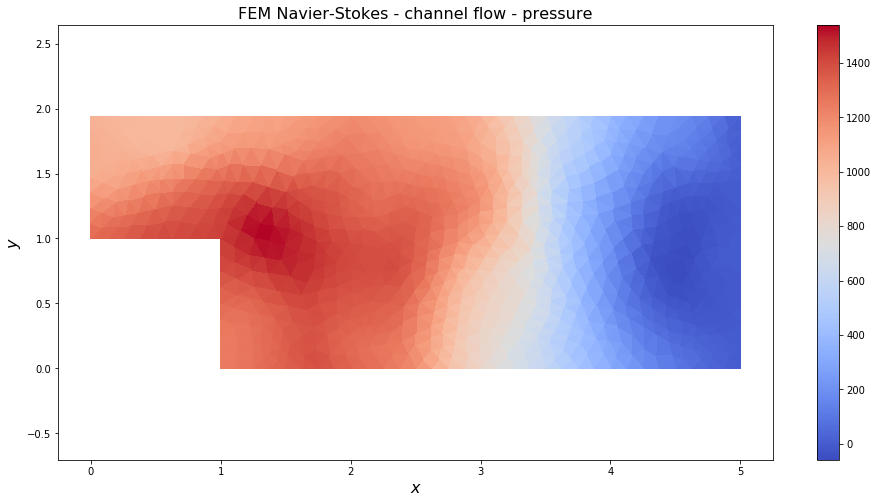

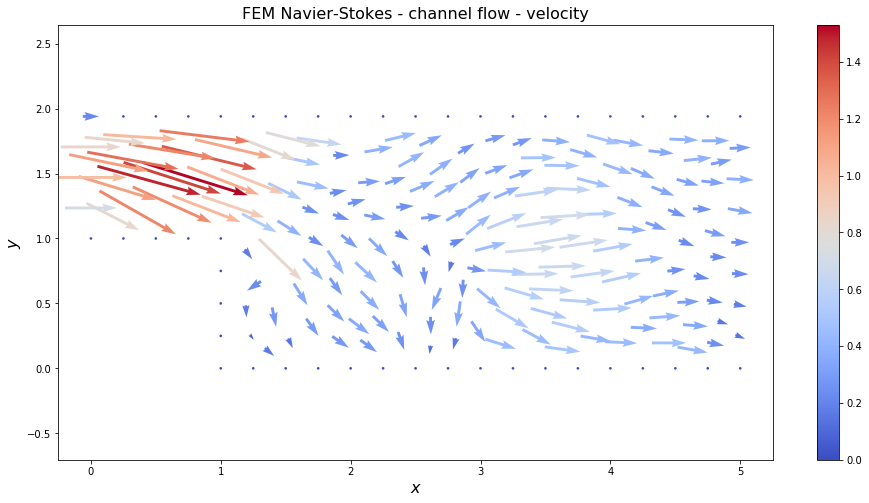

In [18]:
fig1 = plt.figure(figsize=(16, 2.5))
ax1 = fig1.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - channel flow - pressure', fontsize=16)
fd.plot(solver.form_args['p_n'],axes=ax1)
ax1.axis('equal')

fig2 = plt.figure(figsize=(16, 2.5))
ax2 = fig2.add_subplot(111)
ax2.set_xlabel('$x$', fontsize=16)
ax2.set_ylabel('$y$', fontsize=16)
ax2.set_title('FEM Navier-Stokes - channel flow - velocity', fontsize=16)
fd.plot(solver.form_args['u_n'],axes=ax2)
ax2.axis('equal')

## Dissolved Phase

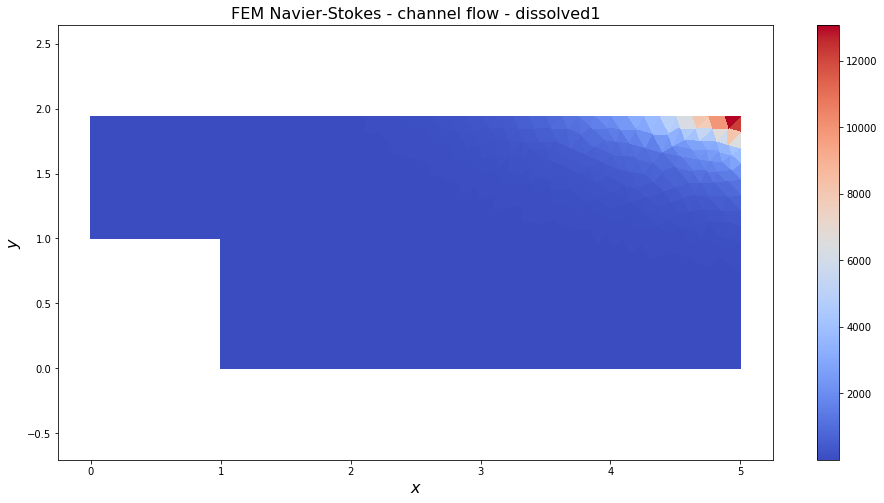

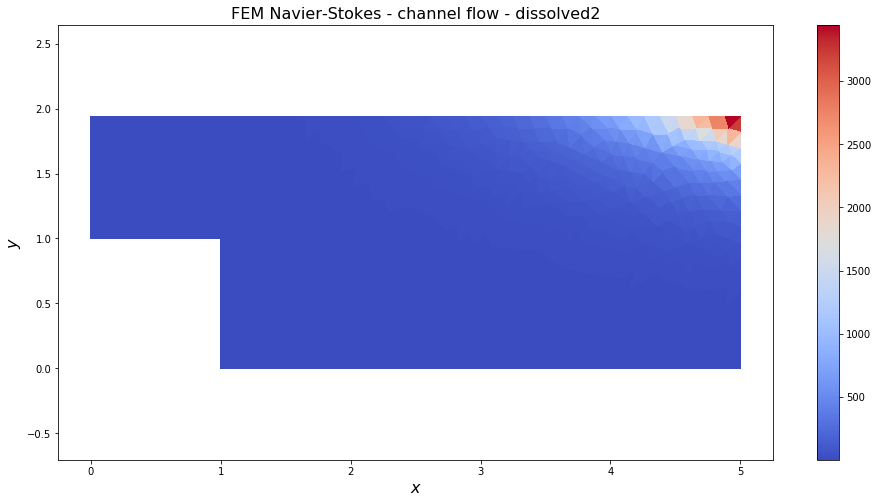

In [19]:
# since each phase contains two species and is a MixedFunctionSpace, use firedrake's split function
# to retrieve each subcomponent
cd1, cd2 = solver.form_args['cd_'].split()

fig3 = plt.figure(figsize=(16, 2.5))
ax3 = fig3.add_subplot(111)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('FEM Navier-Stokes - channel flow - dissolved1', fontsize=16)
fd.plot(cd1,axes=ax3)
ax3.axis('equal')

fig4 = plt.figure(figsize=(16, 2.5))
ax4 = fig4.add_subplot(111)
ax4.set_xlabel('$x$', fontsize=16)
ax4.set_ylabel('$y$', fontsize=16)
ax4.set_title('FEM Navier-Stokes - channel flow - dissolved2', fontsize=16)
fd.plot(cd2, axes=ax4)
ax4.axis('equal')

## Suspended Phase

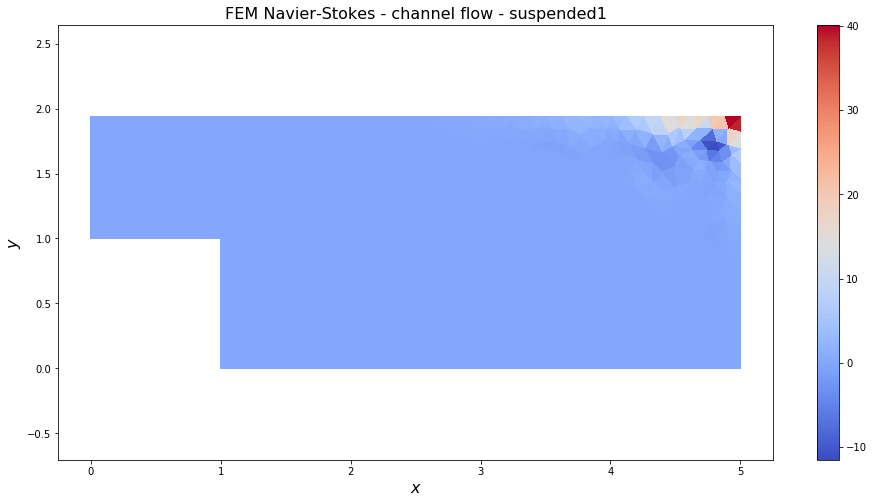

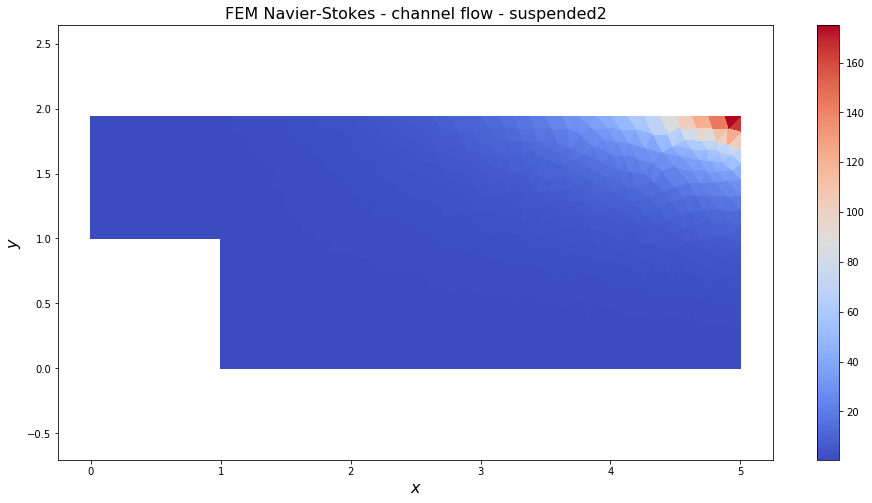

In [20]:
# since each phase contains two species and is a MixedFunctionSpace, use firedrake's split function
# to retrieve each subcomponent
cs1, cs2 = solver.form_args['cs_'].split()

fig5 = plt.figure(figsize=(16, 2.5))
ax5 = fig5.add_subplot(111)
ax5.set_xlabel('$x$', fontsize=16)
ax5.set_ylabel('$y$', fontsize=16)
ax5.set_title('FEM Navier-Stokes - channel flow - suspended1', fontsize=16)
fd.plot(cs1, axes=ax5)
ax5.axis('equal')

fig6 = plt.figure(figsize=(16, 2.5))
ax6 = fig6.add_subplot(111)
ax6.set_xlabel('$x$', fontsize=16)
ax6.set_ylabel('$y$', fontsize=16)
ax6.set_title('FEM Navier-Stokes - channel flow - suspended2', fontsize=16)
fd.plot(cs2, axes=ax6)
ax6.axis('equal')

## Sediment Phase

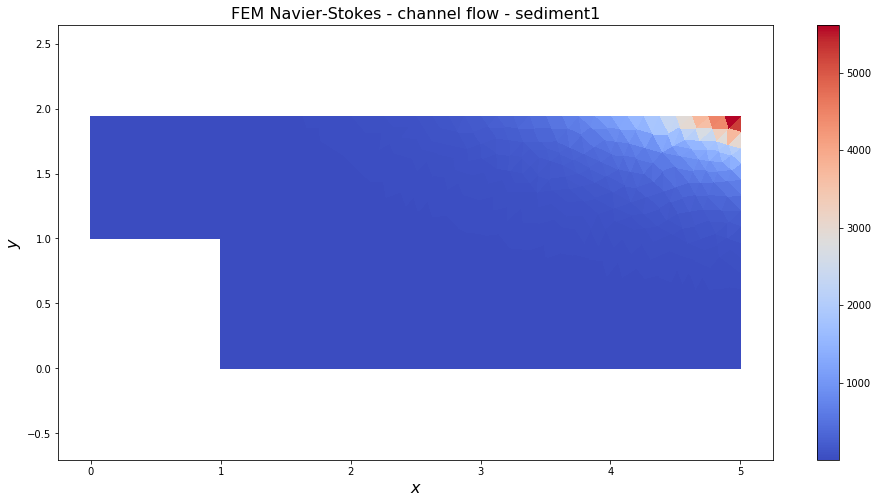

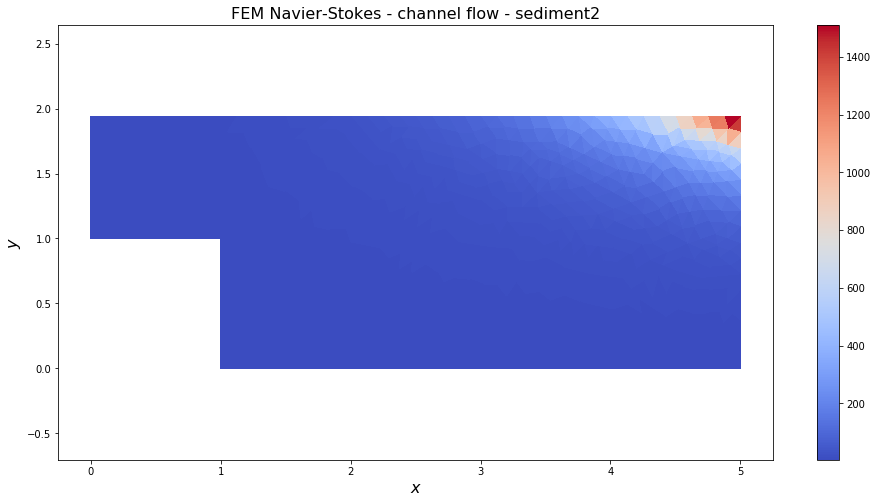

In [21]:
# since each phase contains two species and is a MixedFunctionSpace, use firedrake's split function
# to retrieve each subcomponent
as1, as2 = solver.form_args['as_'].split()

fig7 = plt.figure(figsize=(16, 2.5))
ax7 = fig7.add_subplot(111)
ax7.set_xlabel('$x$', fontsize=16)
ax7.set_ylabel('$y$', fontsize=16)
ax7.set_title('FEM Navier-Stokes - channel flow - sediment1', fontsize=16)
fd.plot(as1, axes=ax7)
ax7.axis('equal')

fig8 = plt.figure(figsize=(16, 2.5))
ax8 = fig8.add_subplot(111)
ax8.set_xlabel('$x$', fontsize=16)
ax8.set_ylabel('$y$', fontsize=16)
ax8.set_title('FEM Navier-Stokes - channel flow - sediment2', fontsize=16)
fd.plot(as2, axes=ax8)
ax8.axis('equal')

## Exact MMS Solution

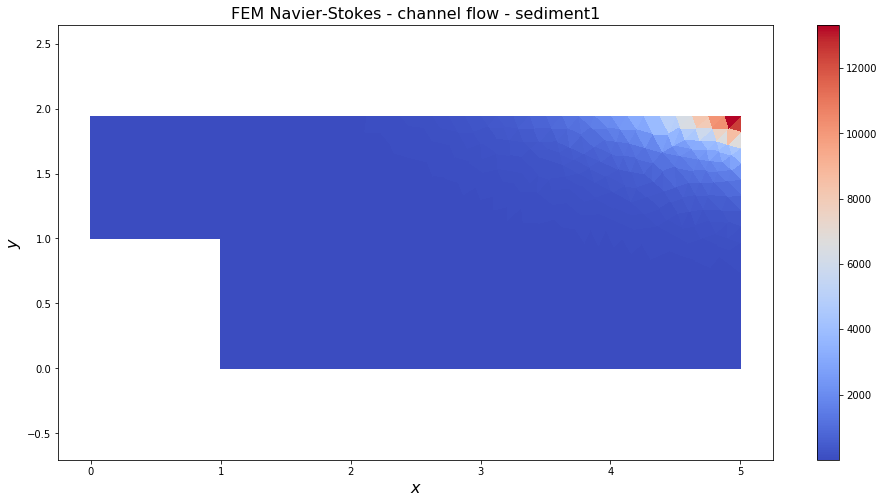

In [31]:
x, y = fd.SpatialCoordinate(solver.mesh)
c_exact = fd.interpolate(fd.exp(x*y*fd.Constant(1)), solver.V['cd'][0])

fig9 = plt.figure(figsize=(16, 2.5))
ax9 = fig9.add_subplot(111)
ax9.set_xlabel('$x$', fontsize=16)
ax9.set_ylabel('$y$', fontsize=16)
ax9.set_title('FEM Navier-Stokes - channel flow - sediment1', fontsize=16)
fd.plot(c_exact, axes=ax9)
ax9.axis('equal')

# MMS Code Verification

## Spatial discretization

In [44]:
import numpy.linalg as nl

solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace, 'cs': fd.MixedFunctionSpace, 'cd' : fd.MixedFunctionSpace, 'as' : fd.MixedFunctionSpace},
'degree': {'u': 2, 'p': 1, 'cs': 1, 'cd' : 1, 'as' : 1},
'order' : {'u': 1, 'p': 1, 'cs' : 2, 'cd' : 2, 'as' : 2, 'cdcsas' : 2},
'linear_solver': {'u': 'gmres', 'p': 'gmres', 'cs': 'gmres', 'cd': 'gmres', 'as': 'gmres'},
'subsystem_class' : {'up': navier_stokes, 'cdcsas' : radio_transport_mms},
'precond': {'u': 'sor', 'p' : 'sor', 'cs': 'sor', 'cd': 'sor', 'as': 'sor'},
'dt' : 0.001,
'T': 2.0
}
)

error_fd_norm = []
dx_array = []

for i in range(1, 9):
    print(i)
    mesh = fd.Mesh("../../meshes/step%d.msh" % i)
    x, y = fd.SpatialCoordinate(mesh)
    # setup a function space to obtain the cell volumes
    DG0 = fd.FunctionSpace(mesh, 'DG', 0)
    b = fd.Function(DG0).interpolate(fd.CellVolume(mesh))
    mean = b.dat.data.mean()
    
    # add subsystems
    solver = pde_solver([['u', 'p']], mesh, solver_parameters)
    solver.add_subsystem(['cd', 'cs', 'as'], solver_parameters)
    #setup system and define subsystems
    solver.setup_constants()
    solver.define(['u', 'p', 'u'], 'up')
    solver.define(['cd', 'cs', 'as'], 'cdcsas')
    solver.setup_bcs()

    #setup initial condition
    x, y = fd.SpatialCoordinate(mesh)
    c = fd.exp(x*y*solver.t)
    solver.setup_initial('cd_n', c, mixedspace=True, index=0)

    #solve
    solver.solve(time_update=True)
    cd1, cd2 = solver.form_args['cd_n'].split()
    c_exact = fd.interpolate(fd.exp(x*y*fd.Constant(solver.prm['T'])), solver.V['cd'][0])
    
    # track error
    error_fd_norm.append(fd.errornorm(c_exact, cd1))
    dx_array.append((np.sqrt(2*mean)))
    


1
time = 1.000
time = 2.000
2
time = 1.000
time = 2.000
3
time = 1.000
time = 2.000
4
time = 1.000
time = 2.000
5
time = 1.000
time = 2.000
6
time = 1.000
time = 2.000
7
time = 1.000
time = 2.000
8
time = 1.000
time = 2.000


In [45]:
print(error_fd_norm)
print(dx_array)

(1216,)
[14563802.39794486, 11551441.020526053, 6298772.207116633, 5200819.307955687, 4972548.157212924, 2076533.8954611889, 1661107.1876692604, 826771.445019483]
[0.42573465914816, 0.32672383790851367, 0.250179791465166, 0.21511995663973357, 0.17350448475003089, 0.12758093232819886, 0.10857540184672981, 0.08716796014080615]


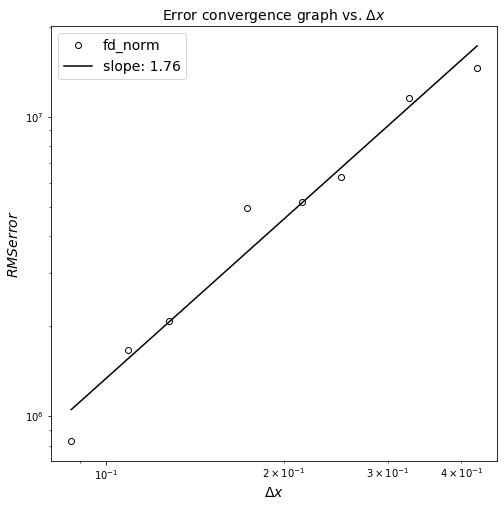

In [46]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
# plot error map

ax1.loglog(dx_array, error_fd_norm, 'o', label='fd_norm', color='k', markerfacecolor='None')
ax1.set_xlabel('$\Delta x$', fontsize=14)
ax1.set_ylabel('$RMS error$', fontsize=14)
ax1.set_title('Error convergence graph vs. $\Delta x$', fontsize=14)
ax1.legend(loc='best', fontsize=14)

# line fit
start_fit = 0
line_fit_uniform_fd = np.polyfit(np.log(dx_array[start_fit:]), np.log(error_fd_norm[start_fit:]), 1)

ax1.loglog(dx_array, np.exp(line_fit_uniform_fd[1]) * dx_array**(line_fit_uniform_fd[0]), 'k-', label = 'slope: {:.2f}'.format(line_fit_uniform_fd[0]))
ax1.legend(loc='best', fontsize=14)


## Temporal discretization

In [39]:
import numpy.linalg as nl

deltat = 0.01


solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace, 'cs': fd.MixedFunctionSpace, 'cd' : fd.MixedFunctionSpace, 'as' : fd.MixedFunctionSpace},
'degree': {'u': 2, 'p': 1, 'cs': 1, 'cd' : 1, 'as' : 1},
'order' : {'u': 1, 'p': 1, 'cs' : 2, 'cd' : 2, 'as' : 2, 'cdcsas' : 2},
'linear_solver': {'u': 'gmres', 'p': 'gmres', 'cs': 'gmres', 'cd': 'gmres', 'as': 'gmres'},
'subsystem_class' : {'up': navier_stokes, 'cdcsas' : radio_transport_mms},
'precond': {'u': 'sor', 'p' : 'sor', 'cs': 'sor', 'cd': 'sor', 'as': 'sor'},
'dt' : deltat,
'T': 0.1
}
)

mesh = fd.Mesh("../../meshes/step1.msh")
x, y = fd.SpatialCoordinate(mesh)


error_fd_norm = []
dt_array = []

for i in range(8):
    print(deltat)
    solver_parameters = recursive_update(solver_parameters, {'dt': deltat})
    # create solver and add systems
    solver = pde_solver([['u', 'p']], mesh, solver_parameters)
    solver.add_subsystem(['cd', 'cs', 'as'], solver_parameters)
    #setup system and define subsystems
    solver.setup_constants()
    solver.define(['u', 'p', 'u'], 'up')
    solver.define(['cd', 'cs', 'as'], 'cdcsas')
    solver.setup_bcs()
    
    c = fd.exp(x*y*solver.t)
    solver.setup_initial('cd_n', c, mixedspace=True, index=0)
    # exact solution
    c_exact = fd.interpolate(fd.exp(x*y*fd.Constant(solver.prm['T'])), solver.V['cd'][0])

    #solve
    solver.solve(time_update=True)
    cd1, cd2 = solver.form_args['cd_n'].split()
    
    # track error
    error_fd_norm.append(fd.errornorm(c_exact, cd1))
    
    # divide time step by 2
    deltat /= 2 
    dt_array.append(deltat)

0.01
0.005
0.0025
0.00125
0.000625
0.0003125
0.00015625
7.8125e-05


In [ ]:
print(error_fd_norm)
print(dt_array)

[0.1338315181243955, 0.10455966623353374, 0.054626982477810074, 0.029392207445881967, 0.01727224475008918, 0.006778202685440313, 0.0074531938380071995, 0.008005333396779892]
[0.005, 0.0025, 0.00125, 0.000625, 0.0003125, 0.00015625, 7.8125e-05, 3.90625e-05]
[]


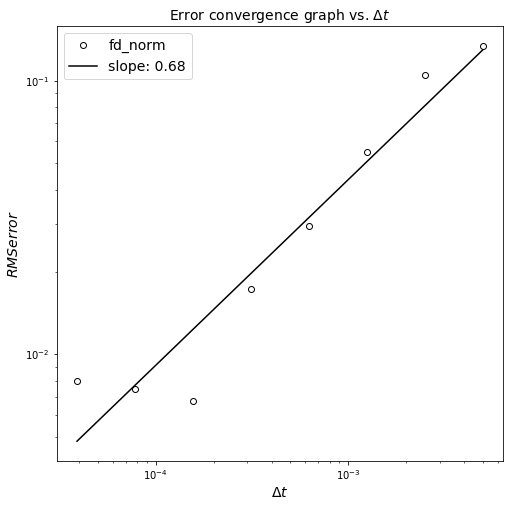

In [43]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
# plot error map

ax1.loglog(dt_array, error_fd_norm, 'o', label='fd_norm', color='k', markerfacecolor='None')

ax1.set_xlabel('$\Delta t$', fontsize=14)
ax1.set_ylabel('$RMS error$', fontsize=14)
ax1.set_title('Error convergence graph vs. $\Delta t$', fontsize=14)
ax1.legend(loc='best', fontsize=14)

# line fit
start_fit = 1
line_fit_uniform_fd = np.polyfit(np.log(dt_array[start_fit:]), np.log(error_fd_norm[start_fit:]), 1)

ax1.loglog(dt_array, np.exp(line_fit_uniform_fd[1]) * dt_array**(line_fit_uniform_fd[0]), 'k-', label = 'slope: {:.2f}'.format(line_fit_uniform_fd[0]))
ax1.legend(loc='best', fontsize=14)